In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA, SparsePCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from numpy.linalg import eig
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
data = pd.read_csv(r"C:\Users\anjal\Downloads\TNBC_data.csv")

In [4]:
data

,Gene ID,221NC,235NC,241NC,257NC,291NC,293NC,254NC,302NC,221TC,235TC,241TC,254TC,257TC,293TC,291TC,302TC,QCPool1,QCPool2,QCPool3
0,NCLN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DNAJC9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CRK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2696100.0,3043200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GPD1L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8647000.0,NaN,NaN,NaN,NaN,84432000.0,NaN,10741000.0
4,MTA1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2621,CACYBP,14809000.0,NaN,NaN,1992500.0,NaN,2794200.0,NaN,NaN,NaN,12168000.0,15569000.0,116690000.0,14214000.0,NaN,6970400.0,14675000.0,10743000.0,9872000.0,6774500.0
2622,RRBP1,282620.0,NaN,NaN,81933.0,NaN,549500.0,256490.0,NaN,759750.0,40872000.0,16161000.0,38284000.0,40373000.0,7365200.0,5942800.0,50443000.0,25160000.0,20392000.0,13413000.0
2623,PA2G4,3906500.0,NaN,NaN,NaN,NaN,1133400.0,NaN,NaN,NaN,4843300.0,11930000.0,54184000.0,2362600.0,NaN,NaN,10198000.0,20240000.0,NaN,749070.0
2624,TLN1,11239000.0,1373900.0,11466000.0,4082100.0,465420.0,11231000.0,3120700.0,1050400.0,2372000.0,21619000.0,27187000.0,28419000.0,26019000.0,10401000.0,17168000.0,27104000.0,181330000.0,52296000.0,11927000.0


In [5]:
data.shape

(2626, 20)

I want to know the protein counts in the patients. so that i can get some idea about the missing values.
one can notice that the number protein count is 2180 which is present in atleast 1 patient for the tumor case. 
which means 440 proteins went undetected in all the patients in the Tumor case.

In [6]:
df = pd.DataFrame(data)

value_columns = df.columns.difference(['Gene ID', 'QCPool1', 'QCPool2', 'QCPool3'])

count_dict = {}

for cutoff in range(1, len(value_columns)//2+1):
    non_nan_cnt_TC = df[[col for col in value_columns if "TC" in col]].count(axis=1)
    rows_to_keep = (non_nan_cnt_TC>=cutoff) 
    count_dict[cutoff] = sum(rows_to_keep)

count_table = pd.DataFrame(count_dict.items(), columns=['TC Cutoff', 'Protein Count'])
print(count_table)

   TC Cutoff  Protein Count
0          1           2180
1          2           1940
2          3           1691
3          4           1459
4          5           1212
5          6            965
6          7            734
7          8            501


If I want to know the protein counts in the patients in NC. so that i can get some idea about the missing values.
one can notice that the number protein count is 1559 which is present in atleast 1 patient for the Non tumor case. 
which means 1067 proteins went undetected in all the patients in the Non Tumor case.

In [7]:
count_dict = {}

for cutoff in range(1, len(value_columns)//2+1):
    non_nan_cnt_NC = df[[col for col in value_columns if "NC" in col]].count(axis=1)
    rows_to_keep = (non_nan_cnt_NC>=cutoff)
    count_dict[cutoff] = sum(rows_to_keep)

count_table = pd.DataFrame(count_dict.items(), columns=['NC Cutoff', 'Protein Count'])
print(count_table)

   NC Cutoff  Protein Count
0          1           1559
1          2           1147
2          3            859
3          4            677
4          5            528
5          6            404
6          7            307
7          8            195


here if we notice only 1512 proteins is been diagnosed in atleast 1 patient out of 2626 proteins. but we cannot retain 1512 proteins because it is present in 1 patient and hence based on 1 patient we we cannot impute the values of other patients because it will be essentially duplicating the values hence we set the cutoff 50%.

In [8]:
count_dict = {}

for cutoff in range(1, len(value_columns)//2+1):
    non_nan_cnt_TC = df[[col for col in value_columns if "TC" in col]].count(axis=1)
    non_nan_cnt_NC = df[[col for col in value_columns if "NC" in col]].count(axis=1)
    rows_to_keep = (non_nan_cnt_TC>=cutoff) & (non_nan_cnt_NC>=cutoff)
    count_dict[cutoff] = sum(rows_to_keep)

count_table = pd.DataFrame(count_dict.items(), columns=['TC and NC Cutoff', 'Protein Count'])
print(count_table)

   TC and NC Cutoff  Protein Count
0                 1           1512
1                 2           1083
2                 3            797
3                 4            631
4                 5            477
5                 6            357
6                 7            269
7                 8            168


In [9]:
rows_to_keep = (non_nan_cnt_TC>=4) & (non_nan_cnt_NC>=4)
retain = df[rows_to_keep]

In [10]:
retain = retain.set_index('Gene ID').T
retain = retain.drop(['QCPool1', 'QCPool2', 'QCPool3'])
retain

Gene ID,GPNMB,YP015,PPP1R12A,UTS2,USP29,IGLV3-19,IGHV3-49,TMEM198,CHD9,MYDGF,...,TUBA1A,SERBP1,KHSRP,PLIN4,PARK7,COL12A1,ACO2,RRBP1,TLN1,EMILIN1
221NC,10854000.0,15431000.0,2587100.0,31090000.0,141350000.0,5217900.0,NaN,NaN,337700000.0,3841200.0,...,79390000.0,12371000.0,10178000.0,152560000.0,53250000.0,NaN,474750.0,282620.0,11239000.0,NaN
235NC,NaN,16334000.0,1095900.0,17627000.0,11587000.0,NaN,NaN,99329000.0,53950000.0,NaN,...,33000000.0,583440.0,NaN,83515000.0,10825000.0,NaN,NaN,NaN,1373900.0,NaN
241NC,NaN,10241000.0,988680.0,9646800.0,51832000.0,23535000.0,13947000.0,108000000.0,398900000.0,NaN,...,33499000.0,NaN,NaN,42868000.0,16012000.0,NaN,NaN,NaN,11466000.0,828640.0
257NC,NaN,12986000.0,924380.0,8424100.0,14458000.0,6358300.0,NaN,NaN,143530000.0,3489900.0,...,34195000.0,2909500.0,1163800.0,94882000.0,16770000.0,NaN,5269000.0,81933.0,4082100.0,221660.0
291NC,3492100.0,4763900.0,NaN,2931300.0,35289000.0,17571000.0,4898200.0,1760700.0,220840000.0,NaN,...,7058200.0,468820.0,NaN,742190.0,11032000.0,423920.0,NaN,NaN,465420.0,NaN
293NC,8980900.0,NaN,1266400.0,30161000.0,5597600.0,2562200.0,NaN,1777100.0,33940000.0,2526000.0,...,278550000.0,3816300.0,6648000.0,30074000.0,24812000.0,299370.0,4166800.0,549500.0,11231000.0,NaN
254NC,NaN,15211000.0,1223100.0,16635000.0,178520000.0,16453000.0,4763100.0,653980000.0,689260000.0,5977200.0,...,33236000.0,6284900.0,1036900.0,30095000.0,30851000.0,314740.0,422870.0,256490.0,3120700.0,1887300.0
302NC,4883200.0,8181600.0,838750.0,NaN,45673000.0,7536800.0,4354500.0,2019100.0,398530000.0,NaN,...,52515000.0,453110.0,NaN,16882000.0,15184000.0,16217000.0,NaN,NaN,1050400.0,4173800.0
221TC,6025900.0,9608100.0,2124000.0,33082000.0,70533000.0,4152900.0,NaN,1529000.0,843660000.0,NaN,...,47491000.0,8895400.0,11023000.0,4189600.0,13139000.0,4113700.0,NaN,759750.0,2372000.0,3720600.0
235TC,56819000.0,13024000.0,1421800.0,NaN,106960000.0,13834000.0,2213400.0,NaN,226970000.0,NaN,...,289310000.0,32703000.0,13953000.0,1227900.0,117170000.0,35485000.0,32323000.0,40872000.0,21619000.0,14283000.0


In [11]:
scaler = MinMaxScaler()
retain_df = pd.DataFrame(scaler.fit_transform(retain), index = retain.index, columns = retain.columns)
retain_df

Gene ID,GPNMB,YP015,PPP1R12A,UTS2,USP29,IGLV3-19,IGHV3-49,TMEM198,CHD9,MYDGF,...,TUBA1A,SERBP1,KHSRP,PLIN4,PARK7,COL12A1,ACO2,RRBP1,TLN1,EMILIN1
221NC,0.138052,0.242329,0.478286,0.206838,0.468884,0.126626,NaN,NaN,0.375142,0.081867,...,0.076890,0.369548,0.128912,1.000000,0.307662,NaN,0.004399,0.003985,0.385410,NaN
235NC,NaN,0.262843,0.070347,0.107947,0.020687,NaN,NaN,0.150610,0.024712,NaN,...,0.027576,0.004041,NaN,0.547353,0.000000,NaN,NaN,NaN,0.032500,NaN
241NC,NaN,0.124426,0.041015,0.049328,0.159692,1.000000,1.000000,0.163889,0.450724,NaN,...,0.028107,NaN,NaN,0.280878,0.037616,NaN,NaN,NaN,0.393530,0.012800
257NC,NaN,0.186785,0.023425,0.040347,0.030604,0.181001,NaN,NaN,0.135343,0.060000,...,0.028847,0.076167,0.003582,0.621873,0.043113,NaN,0.154271,0.000000,0.129382,0.000000
291NC,0.000000,0.000000,NaN,0.000000,0.102553,0.715632,0.228813,0.001195,0.230821,NaN,...,0.000000,0.000487,NaN,0.004709,0.001501,0.000334,NaN,NaN,0.000000,NaN
293NC,0.102927,NaN,0.116990,0.200014,0.000000,0.000000,NaN,0.001220,0.000000,0.000000,...,0.288599,0.104285,0.079832,0.197003,0.101432,0.000000,0.119815,0.009284,0.385123,NaN
254NC,NaN,0.237331,0.105144,0.100660,0.597268,0.662325,0.217299,1.000000,0.809317,0.214827,...,0.027827,0.180831,0.001818,0.197141,0.145226,0.000041,0.002777,0.003466,0.094989,0.035124
302NC,0.026086,0.077641,0.000000,NaN,0.138419,0.237193,0.182476,0.001591,0.450267,NaN,...,0.048321,0.000000,NaN,0.110519,0.031611,0.042703,NaN,NaN,0.020927,0.083341
221TC,0.047514,0.110048,0.351598,0.221470,0.224285,0.075846,NaN,0.000840,1.000000,NaN,...,0.042981,0.261777,0.140660,0.027310,0.016781,0.010233,NaN,0.013459,0.068205,0.073784
235TC,1.000000,0.187648,0.159502,NaN,0.350102,0.537449,0.000000,NaN,0.238391,NaN,...,0.300037,1.000000,0.181398,0.007893,0.771203,0.094395,1.000000,0.809952,0.756740,0.296519


# Data Cleaning

In [12]:
NC_data = retain_df.loc['221NC':'302NC']
NC_data

Gene ID,GPNMB,YP015,PPP1R12A,UTS2,USP29,IGLV3-19,IGHV3-49,TMEM198,CHD9,MYDGF,...,TUBA1A,SERBP1,KHSRP,PLIN4,PARK7,COL12A1,ACO2,RRBP1,TLN1,EMILIN1
221NC,0.138052,0.242329,0.478286,0.206838,0.468884,0.126626,NaN,NaN,0.375142,0.081867,...,0.076890,0.369548,0.128912,1.000000,0.307662,NaN,0.004399,0.003985,0.385410,NaN
235NC,NaN,0.262843,0.070347,0.107947,0.020687,NaN,NaN,0.150610,0.024712,NaN,...,0.027576,0.004041,NaN,0.547353,0.000000,NaN,NaN,NaN,0.032500,NaN
241NC,NaN,0.124426,0.041015,0.049328,0.159692,1.000000,1.000000,0.163889,0.450724,NaN,...,0.028107,NaN,NaN,0.280878,0.037616,NaN,NaN,NaN,0.393530,0.012800
257NC,NaN,0.186785,0.023425,0.040347,0.030604,0.181001,NaN,NaN,0.135343,0.060000,...,0.028847,0.076167,0.003582,0.621873,0.043113,NaN,0.154271,0.000000,0.129382,0.000000
291NC,0.000000,0.000000,NaN,0.000000,0.102553,0.715632,0.228813,0.001195,0.230821,NaN,...,0.000000,0.000487,NaN,0.004709,0.001501,0.000334,NaN,NaN,0.000000,NaN
293NC,0.102927,NaN,0.116990,0.200014,0.000000,0.000000,NaN,0.001220,0.000000,0.000000,...,0.288599,0.104285,0.079832,0.197003,0.101432,0.000000,0.119815,0.009284,0.385123,NaN
254NC,NaN,0.237331,0.105144,0.100660,0.597268,0.662325,0.217299,1.000000,0.809317,0.214827,...,0.027827,0.180831,0.001818,0.197141,0.145226,0.000041,0.002777,0.003466,0.094989,0.035124
302NC,0.026086,0.077641,0.000000,NaN,0.138419,0.237193,0.182476,0.001591,0.450267,NaN,...,0.048321,0.000000,NaN,0.110519,0.031611,0.042703,NaN,NaN,0.020927,0.083341


In [13]:
TC_data = retain_df.loc['221TC':'302TC']
TC_data

Gene ID,GPNMB,YP015,PPP1R12A,UTS2,USP29,IGLV3-19,IGHV3-49,TMEM198,CHD9,MYDGF,...,TUBA1A,SERBP1,KHSRP,PLIN4,PARK7,COL12A1,ACO2,RRBP1,TLN1,EMILIN1
221TC,0.047514,0.110048,0.351598,0.221470,0.224285,0.075846,NaN,0.000840,1.000000,NaN,...,0.042981,0.261777,0.140660,0.027310,0.016781,0.010233,NaN,0.013459,0.068205,0.073784
235TC,1.000000,0.187648,0.159502,NaN,0.350102,0.537449,0.000000,NaN,0.238391,NaN,...,0.300037,1.000000,0.181398,0.007893,0.771203,0.094395,1.000000,0.809952,0.756740,0.296519
241TC,0.383219,0.519163,0.269967,0.446586,0.203934,0.152030,0.585541,0.000000,0.082646,NaN,...,0.722181,0.582727,0.092770,0.000000,0.084514,0.443354,0.337084,0.319276,0.955927,0.149680
254TC,0.145778,1.000000,1.000000,0.925444,0.631704,0.705047,NaN,NaN,0.228758,1.000000,...,1.000000,0.706170,1.000000,0.006493,0.546503,0.274609,0.587014,0.758563,1.000000,0.353751
257TC,0.290939,0.516028,0.472103,0.851769,0.168987,0.833403,NaN,0.607994,0.110001,0.509679,...,0.647335,0.948806,0.210888,NaN,1.000000,0.977653,0.296801,0.800044,0.914143,1.000000
293TC,NaN,0.216158,NaN,0.346064,1.000000,0.707001,0.273676,0.001985,0.211925,0.031833,...,0.161995,0.084812,0.088594,NaN,0.021284,1.000000,0.000000,0.144621,0.355431,0.930032
291TC,0.236164,0.346761,0.174383,0.134133,0.243710,0.472555,0.139003,0.001420,0.309119,NaN,...,0.139916,0.062474,0.000000,NaN,0.068951,0.142403,NaN,0.116377,0.597511,0.181037
302TC,0.755508,0.662874,0.181195,1.000000,0.356526,NaN,0.233552,NaN,0.368226,0.018033,...,0.478539,0.636309,0.154592,0.013264,0.162972,0.246335,0.753415,1.000000,0.952958,0.226994


In [22]:
sns.set(rc={'figure.figsize': (6, 6)})

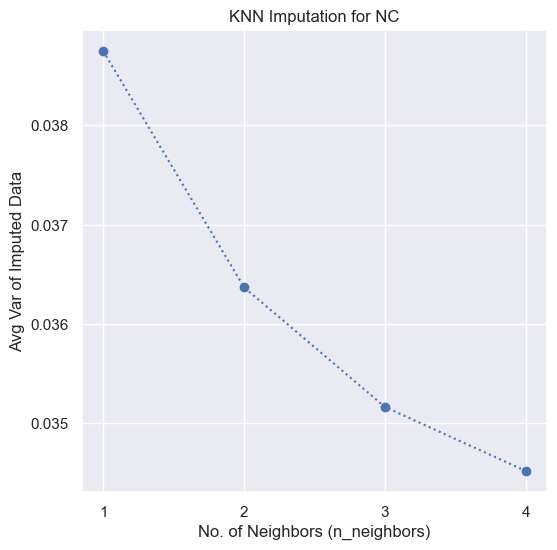

In [23]:
import matplotlib.pyplot as plt

mean_var = []
for i in range(1, 5):
    knn_imputer = KNNImputer(n_neighbors=i)
    imputed_nc = knn_imputer.fit_transform(NC_data)
    imputed_nc_data = pd.DataFrame(imputed_nc, columns=NC_data.columns, index=NC_data.index)

    mean_variance = np.var(imputed_nc_data).mean()
    mean_var.append(mean_variance)

plt.plot(range(1, 5), mean_var, marker='o', linestyle='dotted')
plt.xlabel('No. of Neighbors (n_neighbors)')
plt.ylabel('Avg Var of Imputed Data')
plt.title('KNN Imputation for NC')

# Set integer values on the x-axis
plt.xticks(range(1, 5))

plt.show()


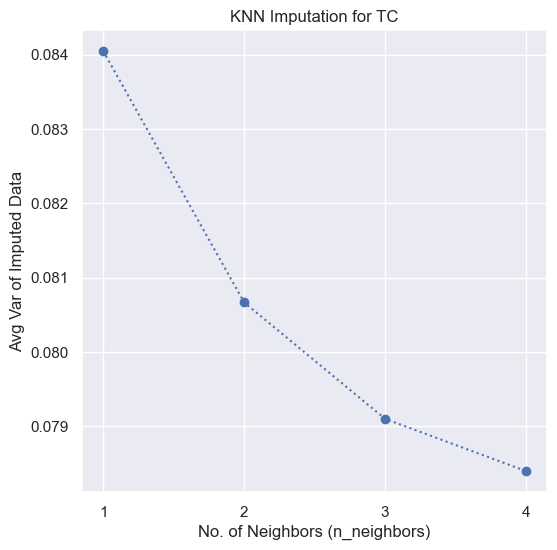

In [24]:
mean_var = []
for i in range(1,5):
    knn_imputer = KNNImputer(n_neighbors=i)
    imputed_tc = knn_imputer.fit_transform(TC_data)
    imputed_tc_data = pd.DataFrame(imputed_tc, columns=TC_data.columns, index=TC_data.index)
    
    mean_variance=np.var(imputed_tc_data).mean()
    mean_var.append(mean_variance)
    
plt.plot(range(1, 5), mean_var, marker='o', linestyle='dotted')
plt.xlabel('No. of Neighbors (n_neighbors)')
plt.ylabel('Avg Var of Imputed Data')
plt.title('KNN Imputation for TC')
plt.xticks(range(1, 5))

plt.show()


In [15]:
knn_imputer = KNNImputer(n_neighbors=2)
imputed_tc = knn_imputer.fit_transform(TC_data)
imputed_tc_data = pd.DataFrame(imputed_tc, columns=TC_data.columns, index=TC_data.index)
imputed_tc_data

Gene ID,GPNMB,YP015,PPP1R12A,UTS2,USP29,IGLV3-19,IGHV3-49,TMEM198,CHD9,MYDGF,...,TUBA1A,SERBP1,KHSRP,PLIN4,PARK7,COL12A1,ACO2,RRBP1,TLN1,EMILIN1
221TC,0.047514,0.110048,0.351598,0.221470,0.224285,0.075846,0.206339,0.000840,1.000000,0.024933,...,0.042981,0.261777,0.140660,0.027310,0.016781,0.010233,0.500000,0.013459,0.068205,0.073784
235TC,1.000000,0.187648,0.159502,0.723293,0.350102,0.537449,0.000000,0.000710,0.238391,0.263856,...,0.300037,1.000000,0.181398,0.007893,0.771203,0.094395,1.000000,0.809952,0.756740,0.296519
241TC,0.383219,0.519163,0.269967,0.446586,0.203934,0.152030,0.585541,0.000000,0.082646,0.263856,...,0.722181,0.582727,0.092770,0.000000,0.084514,0.443354,0.337084,0.319276,0.955927,0.149680
254TC,0.145778,1.000000,1.000000,0.925444,0.631704,0.705047,0.409546,0.303997,0.228758,1.000000,...,1.000000,0.706170,1.000000,0.006493,0.546503,0.274609,0.587014,0.758563,1.000000,0.353751
257TC,0.290939,0.516028,0.472103,0.851769,0.168987,0.833403,0.409546,0.607994,0.110001,0.509679,...,0.647335,0.948806,0.210888,0.006632,1.000000,0.977653,0.296801,0.800044,0.914143,1.000000
293TC,0.141839,0.216158,0.262991,0.346064,1.000000,0.707001,0.273676,0.001985,0.211925,0.031833,...,0.161995,0.084812,0.088594,0.013655,0.021284,1.000000,0.000000,0.144621,0.355431,0.930032
291TC,0.236164,0.346761,0.174383,0.134133,0.243710,0.472555,0.139003,0.001420,0.309119,0.024933,...,0.139916,0.062474,0.000000,0.013655,0.068951,0.142403,0.168542,0.116377,0.597511,0.181037
302TC,0.755508,0.662874,0.181195,1.000000,0.356526,0.344739,0.233552,0.303997,0.368226,0.018033,...,0.478539,0.636309,0.154592,0.013264,0.162972,0.246335,0.753415,1.000000,0.952958,0.226994


In [16]:
knn_imputer = KNNImputer(n_neighbors=2)
imputed_nc = knn_imputer.fit_transform(NC_data)
imputed_nc_data = pd.DataFrame(imputed_nc, columns=NC_data.columns, index=NC_data.index)
imputed_nc_data

Gene ID,GPNMB,YP015,PPP1R12A,UTS2,USP29,IGLV3-19,IGHV3-49,TMEM198,CHD9,MYDGF,...,TUBA1A,SERBP1,KHSRP,PLIN4,PARK7,COL12A1,ACO2,RRBP1,TLN1,EMILIN1
221NC,0.138052,0.242329,0.478286,0.206838,0.468884,0.126626,0.199888,0.001405,0.375142,0.081867,...,0.076890,0.369548,0.128912,1.000000,0.307662,0.021352,0.004399,0.003985,0.385410,0.041670
235NC,0.064507,0.262843,0.070347,0.107947,0.020687,0.209097,0.591238,0.150610,0.024712,0.030000,...,0.027576,0.004041,0.041707,0.547353,0.000000,0.021352,0.137043,0.004642,0.032500,0.041670
241NC,0.013043,0.124426,0.041015,0.049328,0.159692,1.000000,1.000000,0.163889,0.450724,0.107414,...,0.028107,0.002021,0.040825,0.280878,0.037616,0.021372,0.061296,0.006375,0.393530,0.012800
257NC,0.120490,0.186785,0.023425,0.040347,0.030604,0.181001,0.205644,0.001405,0.135343,0.060000,...,0.028847,0.076167,0.003582,0.621873,0.043113,0.021352,0.154271,0.000000,0.129382,0.000000
291NC,0.000000,0.000000,0.011713,0.000000,0.102553,0.715632,0.228813,0.001195,0.230821,0.030000,...,0.000000,0.000487,0.041707,0.004709,0.001501,0.000334,0.137043,0.004642,0.000000,0.041670
293NC,0.102927,0.214557,0.116990,0.200014,0.000000,0.000000,0.205644,0.001220,0.000000,0.000000,...,0.288599,0.104285,0.079832,0.197003,0.101432,0.000000,0.119815,0.009284,0.385123,0.041670
254NC,0.082069,0.237331,0.105144,0.100660,0.597268,0.662325,0.217299,1.000000,0.809317,0.214827,...,0.027827,0.180831,0.001818,0.197141,0.145226,0.000041,0.002777,0.003466,0.094989,0.035124
302NC,0.026086,0.077641,0.000000,0.020174,0.138419,0.237193,0.182476,0.001591,0.450267,0.137414,...,0.048321,0.000000,0.002700,0.110519,0.031611,0.042703,0.078524,0.001733,0.020927,0.083341


In [17]:
common_data = [imputed_nc_data, imputed_tc_data]
common_data = pd.concat(common_data)
common_data

Gene ID,GPNMB,YP015,PPP1R12A,UTS2,USP29,IGLV3-19,IGHV3-49,TMEM198,CHD9,MYDGF,...,TUBA1A,SERBP1,KHSRP,PLIN4,PARK7,COL12A1,ACO2,RRBP1,TLN1,EMILIN1
221NC,0.138052,0.242329,0.478286,0.206838,0.468884,0.126626,0.199888,0.001405,0.375142,0.081867,...,0.076890,0.369548,0.128912,1.000000,0.307662,0.021352,0.004399,0.003985,0.385410,0.041670
235NC,0.064507,0.262843,0.070347,0.107947,0.020687,0.209097,0.591238,0.150610,0.024712,0.030000,...,0.027576,0.004041,0.041707,0.547353,0.000000,0.021352,0.137043,0.004642,0.032500,0.041670
241NC,0.013043,0.124426,0.041015,0.049328,0.159692,1.000000,1.000000,0.163889,0.450724,0.107414,...,0.028107,0.002021,0.040825,0.280878,0.037616,0.021372,0.061296,0.006375,0.393530,0.012800
257NC,0.120490,0.186785,0.023425,0.040347,0.030604,0.181001,0.205644,0.001405,0.135343,0.060000,...,0.028847,0.076167,0.003582,0.621873,0.043113,0.021352,0.154271,0.000000,0.129382,0.000000
291NC,0.000000,0.000000,0.011713,0.000000,0.102553,0.715632,0.228813,0.001195,0.230821,0.030000,...,0.000000,0.000487,0.041707,0.004709,0.001501,0.000334,0.137043,0.004642,0.000000,0.041670
293NC,0.102927,0.214557,0.116990,0.200014,0.000000,0.000000,0.205644,0.001220,0.000000,0.000000,...,0.288599,0.104285,0.079832,0.197003,0.101432,0.000000,0.119815,0.009284,0.385123,0.041670
254NC,0.082069,0.237331,0.105144,0.100660,0.597268,0.662325,0.217299,1.000000,0.809317,0.214827,...,0.027827,0.180831,0.001818,0.197141,0.145226,0.000041,0.002777,0.003466,0.094989,0.035124
302NC,0.026086,0.077641,0.000000,0.020174,0.138419,0.237193,0.182476,0.001591,0.450267,0.137414,...,0.048321,0.000000,0.002700,0.110519,0.031611,0.042703,0.078524,0.001733,0.020927,0.083341
221TC,0.047514,0.110048,0.351598,0.221470,0.224285,0.075846,0.206339,0.000840,1.000000,0.024933,...,0.042981,0.261777,0.140660,0.027310,0.016781,0.010233,0.500000,0.013459,0.068205,0.073784
235TC,1.000000,0.187648,0.159502,0.723293,0.350102,0.537449,0.000000,0.000710,0.238391,0.263856,...,0.300037,1.000000,0.181398,0.007893,0.771203,0.094395,1.000000,0.809952,0.756740,0.296519


In [67]:
common_data = common_data.reset_index(drop=True)

In [68]:
common_data

Gene ID,GPNMB,YP015,PPP1R12A,UTS2,USP29,IGLV3-19,IGHV3-49,TMEM198,CHD9,MYDGF,...,TUBA1A,SERBP1,KHSRP,PLIN4,PARK7,COL12A1,ACO2,RRBP1,TLN1,EMILIN1
0,10854000.0,15431000.0,2587100.0,31090000.0,141350000.0,5217900.0,4558800.0,1898100.0,337700000.0,3841200.0,...,79390000.0,12371000.0,10178000.0,152560000.0,53250000.0,8258185.0,474750.0,282620.0,11239000.0,2197730.0
1,6932050.0,16334000.0,1095900.0,17627000.0,11587000.0,6947550.0,9150750.0,99329000.0,53950000.0,3007950.0,...,33000000.0,583440.0,3905900.0,83515000.0,10825000.0,8258185.0,4717900.0,315716.5,1373900.0,2197730.0
2,4187650.0,10241000.0,988680.0,9646800.0,51832000.0,23535000.0,13947000.0,108000000.0,398900000.0,4251600.0,...,33499000.0,518275.0,3842450.0,42868000.0,16012000.0,8265870.0,2294835.0,402995.0,11466000.0,828640.0
3,9917450.0,12986000.0,924380.0,8424100.0,14458000.0,6358300.0,4626350.0,1898100.0,143530000.0,3489900.0,...,34195000.0,2909500.0,1163800.0,94882000.0,16770000.0,8258185.0,5269000.0,81933.0,4082100.0,221660.0
4,3492100.0,4763900.0,881565.0,2931300.0,35289000.0,17571000.0,4898200.0,1760700.0,220840000.0,3007950.0,...,7058200.0,468820.0,3905900.0,742190.0,11032000.0,423920.0,4717900.0,315716.5,465420.0,2197730.0
5,8980900.0,14208500.0,1266400.0,30161000.0,5597600.0,2562200.0,4626350.0,1777100.0,33940000.0,2526000.0,...,278550000.0,3816300.0,6648000.0,30074000.0,24812000.0,299370.0,4166800.0,549500.0,11231000.0,2197730.0
6,7868600.0,15211000.0,1223100.0,16635000.0,178520000.0,16453000.0,4763100.0,653980000.0,689260000.0,5977200.0,...,33236000.0,6284900.0,1036900.0,30095000.0,30851000.0,314740.0,422870.0,256490.0,3120700.0,1887300.0
7,4883200.0,8181600.0,838750.0,5677700.0,45673000.0,7536800.0,4354500.0,2019100.0,398530000.0,4733550.0,...,52515000.0,453110.0,1100350.0,16882000.0,15184000.0,16217000.0,2845935.0,169211.5,1050400.0,4173800.0
8,6025900.0,9608100.0,2124000.0,33082000.0,70533000.0,4152900.0,4634500.0,1529000.0,843660000.0,2926550.0,...,47491000.0,8895400.0,11023000.0,4189600.0,13139000.0,4113700.0,16328520.0,759750.0,2372000.0,3720600.0
9,56819000.0,13024000.0,1421800.0,101399500.0,106960000.0,13834000.0,2213400.0,1444215.0,226970000.0,6764850.0,...,289310000.0,32703000.0,13953000.0,1227900.0,117170000.0,35485000.0,32323000.0,40872000.0,21619000.0,14283000.0


In [20]:
# Define the minimum and maximum values used in scaling
min_values = retain.min()
max_values = retain.max()

# Denormalize the DataFrame
denormalized_df = common_data

for column in common_data.columns:
    denormalized_df[column] = common_data[column] * (max_values[column] - min_values[column]) + min_values[column]

In [21]:
denormalized_df=pd.DataFrame(denormalized_df, columns=denormalized_df.columns, index = common_data.index)
denormalized_df

Gene ID,GPNMB,YP015,PPP1R12A,UTS2,USP29,IGLV3-19,IGHV3-49,TMEM198,CHD9,MYDGF,...,TUBA1A,SERBP1,KHSRP,PLIN4,PARK7,COL12A1,ACO2,RRBP1,TLN1,EMILIN1
0,10854000.0,15431000.0,2587100.0,31090000.0,141350000.0,5217900.0,4558800.0,1898100.0,337700000.0,3841200.0,...,79390000.0,12371000.0,10178000.0,152560000.0,53250000.0,8258185.0,474750.0,282620.0,11239000.0,2197730.0
1,6932050.0,16334000.0,1095900.0,17627000.0,11587000.0,6947550.0,9150750.0,99329000.0,53950000.0,3007950.0,...,33000000.0,583440.0,3905900.0,83515000.0,10825000.0,8258185.0,4717900.0,315716.5,1373900.0,2197730.0
2,4187650.0,10241000.0,988680.0,9646800.0,51832000.0,23535000.0,13947000.0,108000000.0,398900000.0,4251600.0,...,33499000.0,518275.0,3842450.0,42868000.0,16012000.0,8265870.0,2294835.0,402995.0,11466000.0,828640.0
3,9917450.0,12986000.0,924380.0,8424100.0,14458000.0,6358300.0,4626350.0,1898100.0,143530000.0,3489900.0,...,34195000.0,2909500.0,1163800.0,94882000.0,16770000.0,8258185.0,5269000.0,81933.0,4082100.0,221660.0
4,3492100.0,4763900.0,881565.0,2931300.0,35289000.0,17571000.0,4898200.0,1760700.0,220840000.0,3007950.0,...,7058200.0,468820.0,3905900.0,742190.0,11032000.0,423920.0,4717900.0,315716.5,465420.0,2197730.0
5,8980900.0,14208500.0,1266400.0,30161000.0,5597600.0,2562200.0,4626350.0,1777100.0,33940000.0,2526000.0,...,278550000.0,3816300.0,6648000.0,30074000.0,24812000.0,299370.0,4166800.0,549500.0,11231000.0,2197730.0
6,7868600.0,15211000.0,1223100.0,16635000.0,178520000.0,16453000.0,4763100.0,653980000.0,689260000.0,5977200.0,...,33236000.0,6284900.0,1036900.0,30095000.0,30851000.0,314740.0,422870.0,256490.0,3120700.0,1887300.0
7,4883200.0,8181600.0,838750.0,5677700.0,45673000.0,7536800.0,4354500.0,2019100.0,398530000.0,4733550.0,...,52515000.0,453110.0,1100350.0,16882000.0,15184000.0,16217000.0,2845935.0,169211.5,1050400.0,4173800.0
8,6025900.0,9608100.0,2124000.0,33082000.0,70533000.0,4152900.0,4634500.0,1529000.0,843660000.0,2926550.0,...,47491000.0,8895400.0,11023000.0,4189600.0,13139000.0,4113700.0,16328520.0,759750.0,2372000.0,3720600.0
9,56819000.0,13024000.0,1421800.0,101399500.0,106960000.0,13834000.0,2213400.0,1444215.0,226970000.0,6764850.0,...,289310000.0,32703000.0,13953000.0,1227900.0,117170000.0,35485000.0,32323000.0,40872000.0,21619000.0,14283000.0


In [63]:
denormalized_df = denormalized_df.set_index(retain.index)
denormalized_df

Gene ID,GPNMB,YP015,PPP1R12A,UTS2,USP29,IGLV3-19,IGHV3-49,TMEM198,CHD9,MYDGF,...,TUBA1A,SERBP1,KHSRP,PLIN4,PARK7,COL12A1,ACO2,RRBP1,TLN1,EMILIN1
221NC,10854000.0,15431000.0,2587100.0,31090000.0,141350000.0,5217900.0,4558800.0,1898100.0,337700000.0,3841200.0,...,79390000.0,12371000.0,10178000.0,152560000.0,53250000.0,8258185.0,474750.0,282620.0,11239000.0,2197730.0
235NC,6932050.0,16334000.0,1095900.0,17627000.0,11587000.0,6947550.0,9150750.0,99329000.0,53950000.0,3007950.0,...,33000000.0,583440.0,3905900.0,83515000.0,10825000.0,8258185.0,4717900.0,315716.5,1373900.0,2197730.0
241NC,4187650.0,10241000.0,988680.0,9646800.0,51832000.0,23535000.0,13947000.0,108000000.0,398900000.0,4251600.0,...,33499000.0,518275.0,3842450.0,42868000.0,16012000.0,8265870.0,2294835.0,402995.0,11466000.0,828640.0
257NC,9917450.0,12986000.0,924380.0,8424100.0,14458000.0,6358300.0,4626350.0,1898100.0,143530000.0,3489900.0,...,34195000.0,2909500.0,1163800.0,94882000.0,16770000.0,8258185.0,5269000.0,81933.0,4082100.0,221660.0
291NC,3492100.0,4763900.0,881565.0,2931300.0,35289000.0,17571000.0,4898200.0,1760700.0,220840000.0,3007950.0,...,7058200.0,468820.0,3905900.0,742190.0,11032000.0,423920.0,4717900.0,315716.5,465420.0,2197730.0
293NC,8980900.0,14208500.0,1266400.0,30161000.0,5597600.0,2562200.0,4626350.0,1777100.0,33940000.0,2526000.0,...,278550000.0,3816300.0,6648000.0,30074000.0,24812000.0,299370.0,4166800.0,549500.0,11231000.0,2197730.0
254NC,7868600.0,15211000.0,1223100.0,16635000.0,178520000.0,16453000.0,4763100.0,653980000.0,689260000.0,5977200.0,...,33236000.0,6284900.0,1036900.0,30095000.0,30851000.0,314740.0,422870.0,256490.0,3120700.0,1887300.0
302NC,4883200.0,8181600.0,838750.0,5677700.0,45673000.0,7536800.0,4354500.0,2019100.0,398530000.0,4733550.0,...,52515000.0,453110.0,1100350.0,16882000.0,15184000.0,16217000.0,2845935.0,169211.5,1050400.0,4173800.0
221TC,6025900.0,9608100.0,2124000.0,33082000.0,70533000.0,4152900.0,4634500.0,1529000.0,843660000.0,2926550.0,...,47491000.0,8895400.0,11023000.0,4189600.0,13139000.0,4113700.0,16328520.0,759750.0,2372000.0,3720600.0
235TC,56819000.0,13024000.0,1421800.0,101399500.0,106960000.0,13834000.0,2213400.0,1444215.0,226970000.0,6764850.0,...,289310000.0,32703000.0,13953000.0,1227900.0,117170000.0,35485000.0,32323000.0,40872000.0,21619000.0,14283000.0


In [69]:
common_data.to_csv('tumor_impute.csv', index=False)

In [23]:
variance = np.var(common_data).mean()
variance

1.0928893874709854e+17

The assumption behind using KNN for missing values is that a point value can be approximated by the values of the points that are closest to it, based on other variables.

In [46]:
scaler = StandardScaler()
common_data_scl = pd.DataFrame(scaler.fit_transform(denormalized_df), columns=common_data.columns, index=common_data.index)
# sigma = common_data.cov()
# lambda_, eig_vec = eig(np.array(sigma))
# frame = pd.DataFrame({'values': lambda_, 'vector':[str(i) for i in np.transpose(eig_vec)]})

# pca = pd.DataFrame()
# for i in range(len(lambda_)):
#     pca['PCA'+str(i+1)] = np.dot(np.transpose(eig_vec)[i], np.transpose(common_data_scl))
    
# variances = [np.var(pca[i]) for i in pca.columns]
# var_prop = variances/np.sum(variances)
# var_prop

In [65]:
common_data_scl

Gene ID,GPNMB,YP015,PPP1R12A,UTS2,USP29,IGLV3-19,IGHV3-49,TMEM198,CHD9,MYDGF,...,TUBA1A,SERBP1,KHSRP,PLIN4,PARK7,COL12A1,ACO2,RRBP1,TLN1,EMILIN1
0,-0.309443,-0.260420,0.996636,-0.385223,0.673908,-1.033877,-0.509953,-0.575033,0.232901,-0.372054,...,-0.590878,0.164741,-0.039725,2.866660,0.338496,-0.582086,-0.935075,-0.693458,-0.151264,-0.593209
1,-0.581323,-0.177218,-0.656950,-0.680443,-1.049106,-0.757376,1.179527,-0.030236,-1.103852,-0.579447,...,-0.758043,-0.914947,-0.415773,1.263667,-0.714631,-0.582086,-0.470061,-0.691604,-1.126043,-0.593209
2,-0.771572,-0.738621,-0.775846,-0.855435,-0.514727,1.894294,2.944173,0.018249,0.521216,-0.269907,...,-0.756245,-0.920916,-0.419577,0.319980,-0.585873,-0.582022,-0.735609,-0.686714,-0.128834,-0.689593
3,-0.374367,-0.485700,-0.847148,-0.882246,-1.010985,-0.851573,-0.485100,-0.575033,-0.681838,-0.459491,...,-0.753737,-0.701891,-0.580177,1.527571,-0.567057,-0.582086,-0.409664,-0.704701,-0.858443,-0.732325
4,-0.819789,-1.243276,-0.894625,-1.002694,-0.734387,0.940889,-0.385080,-0.575801,-0.317629,-0.579447,...,-0.851524,-0.925446,-0.415773,-0.658039,-0.709493,-0.647863,-0.470061,-0.691604,-1.215811,-0.593209
5,-0.439291,-0.373060,-0.467883,-0.405595,-1.128635,-1.458418,-0.485100,-0.575709,-1.198119,-0.699402,...,0.126790,-0.618832,-0.251368,0.022947,-0.367428,-0.648909,-0.530457,-0.678507,-0.152055,-0.593209
6,-0.516399,-0.280690,-0.515898,-0.702196,1.167457,0.762165,-0.434786,3.071165,1.889108,0.159588,...,-0.757193,-0.392719,-0.587786,0.023434,-0.217520,-0.648780,-0.940761,-0.694922,-0.953440,-0.615063
7,-0.723355,-0.928372,-0.942103,-0.942470,-0.596507,-0.663178,-0.585119,-0.574356,0.519473,-0.149951,...,-0.687722,-0.926885,-0.583982,-0.283327,-0.606426,-0.515264,-0.675213,-0.699811,-1.158008,-0.454093
8,-0.644140,-0.796936,0.483106,-0.341542,-0.266412,-1.204128,-0.482101,-0.577097,2.616490,-0.599707,...,-0.705825,-0.153609,0.010938,-0.578002,-0.657190,-0.616884,0.802369,-0.666728,-1.027420,-0.485999
9,2.876975,-0.482198,-0.295561,1.156539,0.217272,0.343492,-1.372877,-0.577571,-0.288750,0.355631,...,0.165563,2.027061,0.186608,-0.646763,1.925200,-0.353488,2.555234,1.580440,0.874392,0.257598


In [47]:
pca = PCA(0.95)
pc = pca.fit_transform(common_data_scl)

In [48]:
prop_var = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_

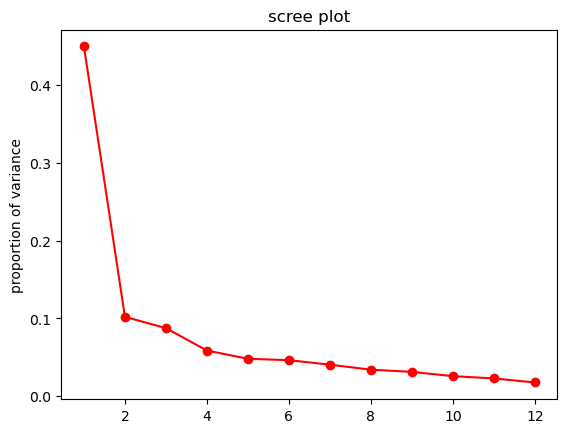

In [49]:
PC_number = np.arange(pca.n_components_)+1

plt.plot(PC_number, prop_var, 'ro-')
plt.title('scree plot')
plt.ylabel('proportion of variance')
plt.show()

In [50]:
pca.n_components_

12

In [51]:
component_label = [f'PCA{i+1}' for i in range(12)]
pca_df = pd.DataFrame(data=pc, columns=component_label)
pca_df

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12
0,-6.655655,-9.908851,2.635057,10.779543,3.599448,4.980233,1.424286,4.679830,7.248749,-3.290346,-5.510443,-3.722259
1,-13.187683,0.246563,4.676972,5.889897,-9.788292,-1.632597,-2.935011,1.642308,-3.575130,8.901591,2.805207,-3.022748
2,-15.784583,13.521117,9.497683,-2.157339,-9.910410,4.019128,1.191316,1.728050,5.548684,-6.134471,3.460681,1.592313
3,-11.633557,-9.357557,-0.453942,6.877557,-2.240172,-2.722374,-1.509033,-0.769016,-3.428355,-0.693161,-0.965194,-0.991883
4,-14.127798,0.162903,1.481835,-5.746655,-0.757436,3.222194,-0.423803,-8.689898,-6.351629,-5.119988,-3.700011,-3.010583
5,-7.884018,-9.269396,-3.756685,5.325724,0.355265,-5.049065,-3.488155,-3.297913,0.996472,-3.148752,3.024181,9.430616
6,-10.386901,4.820784,5.074393,-0.433646,10.193721,7.488336,7.320781,-1.131283,1.987025,6.849039,1.906291,3.325472
7,-13.598561,-1.952631,0.384377,-2.450267,1.599153,2.627178,-1.064618,-2.358951,-3.358193,4.116724,-2.560072,1.519220
8,-7.055842,-5.442794,-1.964003,-4.864762,6.542604,-7.043681,2.631175,4.182001,-0.121860,-2.432881,9.214471,-4.963175
9,15.235678,-5.752172,-10.221137,-4.690587,-8.893093,-3.182461,13.539523,-1.490159,2.696417,1.703942,-2.423267,0.441491


In [52]:
eigenvalues

array([302.32086602,  68.6541115 ,  58.89900696,  39.53759307,
        32.40289689,  31.19969224,  27.33989199,  22.97440162,
        21.09608067,  17.41613605,  15.43039634,  11.93314279])

In [53]:
prop_var.sum()

0.9645466761014166

In [54]:
loadings=pca.components_
feature_imp = np.abs(loadings)
# total_feat_imp = feature_imp.sum(axis=0)

# feature_names = common_data_scl.columns
# feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': total_feat_imp})

# feature_imp_df = feature_imp_df.sort_values(by="Importance",ascending=False)
# print(feature_imp_df)

feature_importance = np.abs(loadings).sum(axis=0)
feature_names = common_data_scl.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

     Feature  Importance
409    PRELP    0.624367
50    AKR1C3    0.615439
42   PRKAR2A    0.608554
183   CAVIN3    0.605711
11    COL5A3    0.602158
..       ...         ...
450     GDI2    0.151864
588      VCP    0.151274
508    RPLP2    0.144985
396    VDAC1    0.137569
438     RPL4    0.124509

[631 rows x 2 columns]


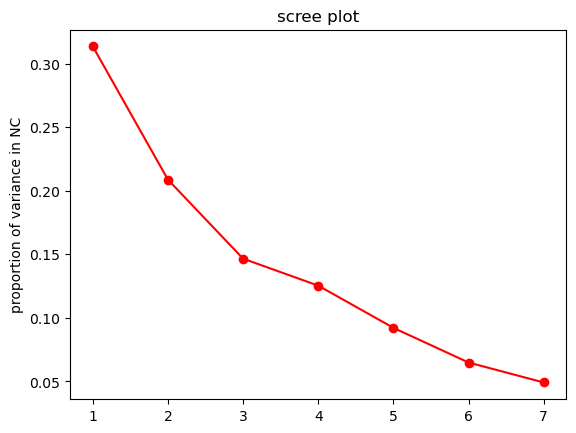

      Feature  Importance
94      MFAP2    0.321864
426    CKMT1A    0.321432
420     PDIA4    0.318752
62       GMDS    0.308879
180  IGKV1-33    0.306815
..        ...         ...
508     RPLP2    0.135681
307      NME2    0.131591
588       VCP    0.130491
516      P4HB    0.128672
500     ALDOA    0.126755

[631 rows x 2 columns]


In [55]:
scaler = StandardScaler()
imputed_nc_data_scl = pd.DataFrame(scaler.fit_transform(imputed_nc_data), columns=imputed_nc_data.columns, index=imputed_nc_data.index)
pca_nc = PCA(0.98)
pc_nc = pca_nc.fit_transform(imputed_nc_data_scl)
prop_var_nc = pca_nc.explained_variance_ratio_
eigenvalues_nc = pca_nc.explained_variance_

PC_nc_number = np.arange(pca_nc.n_components_)+1

plt.plot(PC_nc_number, prop_var_nc, 'ro-')
plt.title('scree plot')
plt.ylabel('proportion of variance in NC')
plt.show()

loadings=pca_nc.components_
feature_imp = np.abs(loadings)
total_feat_imp = feature_imp.sum(axis=0)

feature_names = imputed_nc_data_scl.columns
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': total_feat_imp})

feature_imp_df = feature_imp_df.sort_values(by="Importance",ascending=False)
print(feature_imp_df)

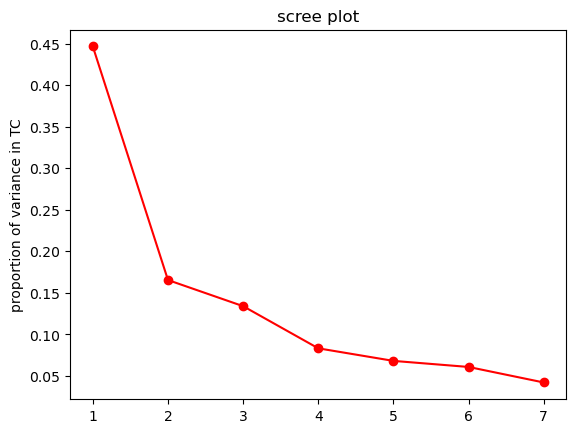

    Feature  Importance
389  SLC4A1    0.352658
522   THBS1    0.351531
239  HNRNPR    0.346187
378     LYZ    0.345570
38     RSU1    0.342627
..      ...         ...
215   RPS18    0.109511
155    RPS6    0.108755
326    NACA    0.106926
508   RPLP2    0.101975
438    RPL4    0.100217

[631 rows x 2 columns]


In [56]:
scaler = StandardScaler()
imputed_tc_data_scl = pd.DataFrame(scaler.fit_transform(imputed_tc_data), columns=imputed_tc_data.columns, index=imputed_tc_data.index)
pca_tc = PCA(0.98)
pc_tc = pca_tc.fit_transform(imputed_tc_data_scl)
prop_var_tc = pca_tc.explained_variance_ratio_
eigenvalues_tc = pca_tc.explained_variance_

PC_tc_number = np.arange(pca_tc.n_components_)+1

plt.plot(PC_tc_number, prop_var_tc, 'ro-')
plt.title('scree plot')
plt.ylabel('proportion of variance in TC')
plt.show()

loadings=pca_tc.components_
feature_imp = np.abs(loadings)
total_feat_imp = feature_imp.sum(axis=0)

feature_names = imputed_tc_data_scl.columns
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': total_feat_imp})

feature_imp_df = feature_imp_df.sort_values(by="Importance",ascending=False)
print(feature_imp_df)

A disadvantage of principal components is that every predictor receives a nonzero weight for every component, so many coefficients are involved even through the effective degrees of freedom with respect to the response model are reduced. Sparse principal components (Witten & Tibshirani, 2008) uses a penalty function to reduce the magnitude of the loadings variables receive in the components. If an L1 penalty is used (as with the lasso, some loadings are shrunk to zero, resulting in some simplicity. Sparse principal components combines some elements of variable clustering, scoring of variables within clusters, and redundancy analysis

In [57]:
percent_var = []
for n_comp in range(0, 2):
    sparse_pca = SparsePCA(n_components=n_comp+1)
    sparse_pca.fit(common_data_scl.T)
    x_sparse_pca = sparse_pca.transform(common_data_scl.T)
    total_var = 100*np.mean(sparse_pca.components_!=0)
    percent_var.append(total_var)
var_explained = [percent_var[0]]+[(percent_var[i+1] - percent_var[i]) for i in range(len(percent_var)-1)]

In [58]:
var_explained = [percent_var[0]]+[(percent_var[i+1] - percent_var[i]) for i in range(len(percent_var)-1)]
sum(var_explained)

78.125

In [59]:
len(np.abs(loadings))

7

#### T test 

In [60]:
nc_scl = common_data_scl.loc['221NC':'302NC']
tc_scl = common_data_scl.loc['221TC':'302TC']

result = stats.ttest_rel(nc_scl,tc_scl)

In [61]:
# Perform paired t-test for each feature and store p-values
p_values = []

for feature in common_data_scl.columns:
    t_statistic, p_value = stats.ttest_rel(nc_scl[feature], tc_scl[feature])
    p_values.append({'Feature': feature, 'P-Value': p_value})

# Create a DataFrame with p-values
p_values_df = pd.DataFrame(p_values)

# Sort the features by p-value in decreasing order
important_features_df = p_values_df.sort_values(by='P-Value', ascending=True)

# Set a significance level (alpha) to determine importance
alpha = 0.05  # You can adjust this significance level as needed

# Filter only the important features
important_features = important_features_df[important_features_df['P-Value'] < alpha]

# Display the important features in decreasing order of importance
print(important_features)

Empty DataFrame
Columns: [Feature, P-Value]
Index: []


### Upregulated Genes

In [62]:
common_data_scl

Gene ID,GPNMB,YP015,PPP1R12A,UTS2,USP29,IGLV3-19,IGHV3-49,TMEM198,CHD9,MYDGF,...,TUBA1A,SERBP1,KHSRP,PLIN4,PARK7,COL12A1,ACO2,RRBP1,TLN1,EMILIN1
0,-0.309443,-0.260420,0.996636,-0.385223,0.673908,-1.033877,-0.509953,-0.575033,0.232901,-0.372054,...,-0.590878,0.164741,-0.039725,2.866660,0.338496,-0.582086,-0.935075,-0.693458,-0.151264,-0.593209
1,-0.581323,-0.177218,-0.656950,-0.680443,-1.049106,-0.757376,1.179527,-0.030236,-1.103852,-0.579447,...,-0.758043,-0.914947,-0.415773,1.263667,-0.714631,-0.582086,-0.470061,-0.691604,-1.126043,-0.593209
2,-0.771572,-0.738621,-0.775846,-0.855435,-0.514727,1.894294,2.944173,0.018249,0.521216,-0.269907,...,-0.756245,-0.920916,-0.419577,0.319980,-0.585873,-0.582022,-0.735609,-0.686714,-0.128834,-0.689593
3,-0.374367,-0.485700,-0.847148,-0.882246,-1.010985,-0.851573,-0.485100,-0.575033,-0.681838,-0.459491,...,-0.753737,-0.701891,-0.580177,1.527571,-0.567057,-0.582086,-0.409664,-0.704701,-0.858443,-0.732325
4,-0.819789,-1.243276,-0.894625,-1.002694,-0.734387,0.940889,-0.385080,-0.575801,-0.317629,-0.579447,...,-0.851524,-0.925446,-0.415773,-0.658039,-0.709493,-0.647863,-0.470061,-0.691604,-1.215811,-0.593209
5,-0.439291,-0.373060,-0.467883,-0.405595,-1.128635,-1.458418,-0.485100,-0.575709,-1.198119,-0.699402,...,0.126790,-0.618832,-0.251368,0.022947,-0.367428,-0.648909,-0.530457,-0.678507,-0.152055,-0.593209
6,-0.516399,-0.280690,-0.515898,-0.702196,1.167457,0.762165,-0.434786,3.071165,1.889108,0.159588,...,-0.757193,-0.392719,-0.587786,0.023434,-0.217520,-0.648780,-0.940761,-0.694922,-0.953440,-0.615063
7,-0.723355,-0.928372,-0.942103,-0.942470,-0.596507,-0.663178,-0.585119,-0.574356,0.519473,-0.149951,...,-0.687722,-0.926885,-0.583982,-0.283327,-0.606426,-0.515264,-0.675213,-0.699811,-1.158008,-0.454093
8,-0.644140,-0.796936,0.483106,-0.341542,-0.266412,-1.204128,-0.482101,-0.577097,2.616490,-0.599707,...,-0.705825,-0.153609,0.010938,-0.578002,-0.657190,-0.616884,0.802369,-0.666728,-1.027420,-0.485999
9,2.876975,-0.482198,-0.295561,1.156539,0.217272,0.343492,-1.372877,-0.577571,-0.288750,0.355631,...,0.165563,2.027061,0.186608,-0.646763,1.925200,-0.353488,2.555234,1.580440,0.874392,0.257598


In [41]:
upregulated_genes = np.log2(common_data_scl.loc['221NC']/common_data_scl.loc['221TC']).sort_values(ascending=False)
upregulated_genes = pd.Series(upregulated_genes)
upregulated_genes = upregulated_genes[upregulated_genes>0]
upregulated_genes

KeyError: '221NC'

In [ ]:
upregulated_genes = np.log2(common_data_scl.loc['235NC']/common_data_scl.loc['235TC']).sort_values(ascending=False)
upregulated_genes = pd.Series(upregulated_genes)
upregulated_genes = upregulated_genes[upregulated_genes>0]
upregulated_genes

In [ ]:
upregulated_genes = np.log2(common_data_scl.loc['241NC']/common_data_scl.loc['241TC']).sort_values(ascending=False)
upregulated_genes = pd.Series(upregulated_genes)
upregulated_genes = upregulated_genes[upregulated_genes>0]
upregulated_genes

In [ ]:
upregulated_genes = np.log2(common_data_scl.loc['254NC']/common_data_scl.loc['254TC']).sort_values(ascending=False)
upregulated_genes = pd.Series(upregulated_genes)
upregulated_genes = upregulated_genes[upregulated_genes>0]
upregulated_genes

In [ ]:
upregulated_genes = np.log2(common_data_scl.loc['257NC']/common_data_scl.loc['257TC']).sort_values(ascending=False)
upregulated_genes = pd.Series(upregulated_genes)
upregulated_genes = upregulated_genes[upregulated_genes>0]
upregulated_genes

In [ ]:
upregulated_genes = np.log2(common_data_scl.loc['293NC']/common_data_scl.loc['293TC']).sort_values(ascending=False)
upregulated_genes = pd.Series(upregulated_genes)
upregulated_genes = upregulated_genes[upregulated_genes>0]
upregulated_genes

In [ ]:
upregulated_genes = np.log2(common_data_scl.loc['291NC']/common_data_scl.loc['291TC']).sort_values(ascending=False)
upregulated_genes = pd.Series(upregulated_genes)
upregulated_genes = upregulated_genes[upregulated_genes>0]
upregulated_genes

In [ ]:
upregulated_genes = np.log2(common_data_scl.loc['302NC']/common_data_scl.loc['302TC']).sort_values(ascending=False)
upregulated_genes = pd.Series(upregulated_genes)
upregulated_genes = upregulated_genes[upregulated_genes>0]
upregulated_genes

In [ ]:
def fibo(n):
    if n==1:
        return 1
    elif n==0:
        return 1
    else:
        for i in range(2,n+1):
            f = fibo(i-1)+fibo(i-2)
    return f

In [ ]:
fibo(4)

In [ ]:
def fact(n):
    f=1
    if n==0:
        return 1
    else:
        for i in range(2,n+1):
            f = f*i
    return f

In [ ]:
fact(5)